In [1]:
# --- 0. CONNECT TO THE QUANTUM LOOM ---
import warnings
import os
import logging
import sys

# 1. Kill Standard Warnings
warnings.simplefilter("ignore")
warnings.filterwarnings("ignore")

# 2. Kill ResourceWarnings (Socket warnings from Qiskit Runtime)
warnings.filterwarnings("ignore", category=ResourceWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

# 3. Kill System Logs (TensorFlow/Qiskit/Urllib3)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
os.environ['QISKIT_SETTINGS'] = '{"suppress_warnings": true}'

logging.getLogger('qiskit').setLevel(logging.CRITICAL)
logging.getLogger('stevedore').setLevel(logging.CRITICAL)
logging.getLogger('urllib3').setLevel(logging.CRITICAL)
logging.getLogger('qiskit_ibm_runtime').setLevel(logging.CRITICAL)

from qiskit_ibm_runtime import QiskitRuntimeService
import os

# Load saved account
try:
    service = QiskitRuntimeService()
    print(f"Connected to IBM Quantum: {service.channel}")
except:
    print("No saved account found.")
    token = input("Please enter your IBM Quantum API Token: ")
    service = QiskitRuntimeService(channel="ibm_quantum_platform", token=token)

Connected to IBM Quantum: ibm_quantum_platform


Connecting to IBM Quantum...
Hardware Selected: ibm_torino
Scanning vacuum topology for a Closed Timelike Loop...
Building the Causality Paradox circuits...
Transpiling with strict physical layout...
Submitting Causality Paradox job to IBM queue...
Job ID: d6g3b0224kpc73emcse0


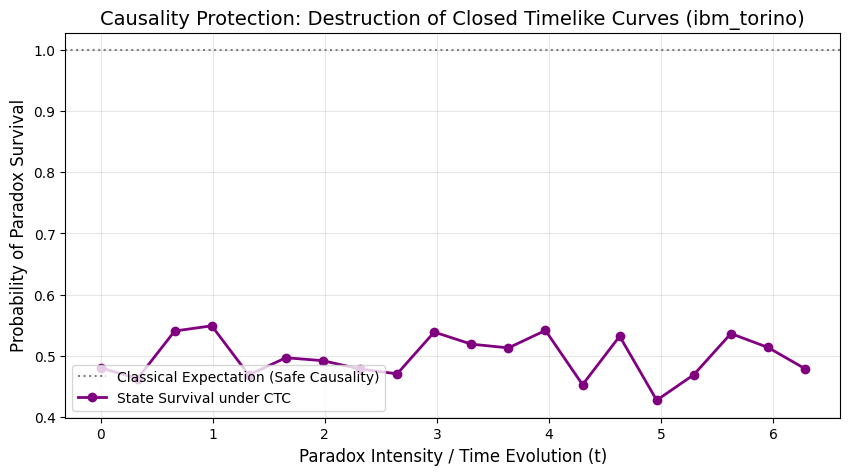

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2

# --- 1. CONNECT TO IBM QUANTUM ---
print("Connecting to IBM Quantum...")
service = QiskitRuntimeService()
backend = service.backend('ibm_torino')
print(f"Hardware Selected: {backend.name}")

# --- 2. LATTICE WEATHER ROUTING (Finding a 4-qubit Ring) ---
print("Scanning vacuum topology for a Closed Timelike Loop...")
target = backend.target
t1_values = {q: (target.qubit_properties[q].t1 * 1e6 if target.qubit_properties[q] else 0) for q in range(target.num_qubits)}

G = nx.Graph()
for edge in target.build_coupling_map().get_edges():
    G.add_edge(edge[0], edge[1])

best_ring = None
best_score = 0.0

# Search for a 4-node cycle (q0-q1-q2-q3-q0)
cycles = nx.cycle_basis(G)
for cycle in cycles:
    if len(cycle) == 4:
        score = sum(t1_values.get(q, 0) for q in cycle) / 4.0
        if score > best_score:
            best_score = score
            best_ring = cycle

if not best_ring:
    print("Warning: No perfect 4-ring found. Falling back to linear chain emulation.")
    best_ring = list(G.nodes)[:4]
else:
    print(f"Optimal Vacuum Ring found: {best_ring}")
    print(f"Average T1 of ring: {best_score:.2f} μs")

# --- 3. DYNAMIC SPACETIME PARAMETERS ---
time_steps = np.linspace(0, 2 * np.pi, 20)
omega = 1.0  # Normal forward time flow

circuits = []
print("Building the Causality Paradox circuits...")

for t in time_steps:
    qr = QuantumRegister(4, 'q')
    cr = ClassicalRegister(1, 'meas')
    qc = QuantumCircuit(qr, cr)
    
    # 1. Initialize the "Grandfather" State at q0 (The Past)
    qc.h(0) 
    
    # 2. Forward Time Evolution (The particle lives its life)
    qc.rz(omega * t, 0)
    
    # 3. Translate the particle through space (q0 -> q1 -> q2 -> q3)
    qc.swap(0, 1)
    qc.rz(omega * t, 1)
    qc.swap(1, 2)
    qc.rz(omega * t, 2)
    qc.swap(2, 3)
    qc.rz(omega * t, 3) # Particle is now in the "Future"
    
    # 4. THE CLOSED TIMELIKE CURVE (The Paradox)
    # We open a wormhole (entanglement bridge) from the Future (q3) back to the Past (q0).
    # We apply a NEGATIVE phase (-omega) to simulate traveling backward in time to kill the grandfather.
    qc.rzz(-omega * t, 3, 0)
    
    # 5. Measure the survival of the original state at the Past coordinate (q0)
    qc.h(0)
    qc.measure(0, 0)
    
    circuits.append(qc)

# --- 4. EXECUTE ON HARDWARE ---
print("Transpiling with strict physical layout...")
pm = generate_preset_pass_manager(target=backend.target, optimization_level=3, initial_layout=best_ring)
isa_circuits = pm.run(circuits)

print("Submitting Causality Paradox job to IBM queue...")
sampler = SamplerV2(mode=backend)
job = sampler.run(isa_circuits)
print(f"Job ID: {job.job_id()}")

result = job.result()

# --- 5. PROCESS DATA ---
survival_probability = []

for i in range(len(time_steps)):
    counts = result[i].data.meas.get_counts()
    total = sum(counts.values())
    
    # Calculate probability of observing the original state |0>
    p_0 = counts.get('0', 0) / total
    survival_probability.append(p_0)

# --- 6. PLOT THE RESULTS ---
plt.figure(figsize=(10, 5))

# Baseline: What it should look like if causality is safe (Flat line at 1.0)
plt.axhline(y=1.0, color='gray', linestyle='dotted', label='Classical Expectation (Safe Causality)')

plt.plot(time_steps, survival_probability, label='State Survival under CTC', color='purple', linewidth=2, marker='o')

plt.title(f"Causality Protection: Destruction of Closed Timelike Curves ({backend.name})", fontsize=14)
plt.xlabel("Paradox Intensity / Time Evolution (t)", fontsize=12)
plt.ylabel("Probability of Paradox Survival", fontsize=12)
plt.legend(loc="lower left")
plt.grid(True, alpha=0.3)
plt.show()